# Segmentation QC

In [1]:
%load_ext autoreload
%autoreload 2
%env ANYWIDGET_HMR=1

env: ANYWIDGET_HMR=1


In [11]:
# macOS requirement
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import celldega as dega
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/lib:' + os.environ.get('DYLD_LIBRARY_PATH', '')

In [3]:
segmentation_approachs = ["Cellpose2", "Cellpose-Default", "InstanSeg-Default", "Xenium-Default"]
directories = ["xenium_skin_cellpose2", "xenium_skin_cellpose_default", "xenium_skin_instanseg_default", "xenium_skin_xenium_default"]
from_stp_list = [True, True, True, True]

In [66]:
for directory, segmentation_approach, from_stp in zip(directories, segmentation_approachs, from_stp_list):
    
    dega.qc.qc_segmentation(transcript_metadata_file=f"data/segmentation_metrics_data/{directory}/partitioned_transcripts_metadata.parquet", 
                          transcript_data_file=f"data/segmentation_metrics_data/{directory}/transcripts_coordinates.csv", 
                          cell_polygon_metadata_file=f"data/segmentation_metrics_data/{directory}/cell_metadata.parquet", 
                          cell_polygon_data_file=f"data/segmentation_metrics_data/{directory}/cell_polygons.parquet", 
                          subset_interval_y_x=[0,20294,0,42748],
                          pixel_size=0.2125, 
                          dataset_name="Xenium-Skin", 
                          segmentation_approach=segmentation_approach, 
                          from_stp=from_stp)

segmentation metrics calculation completed
segmentation metrics calculation completed
segmentation metrics calculation completed
segmentation metrics calculation completed


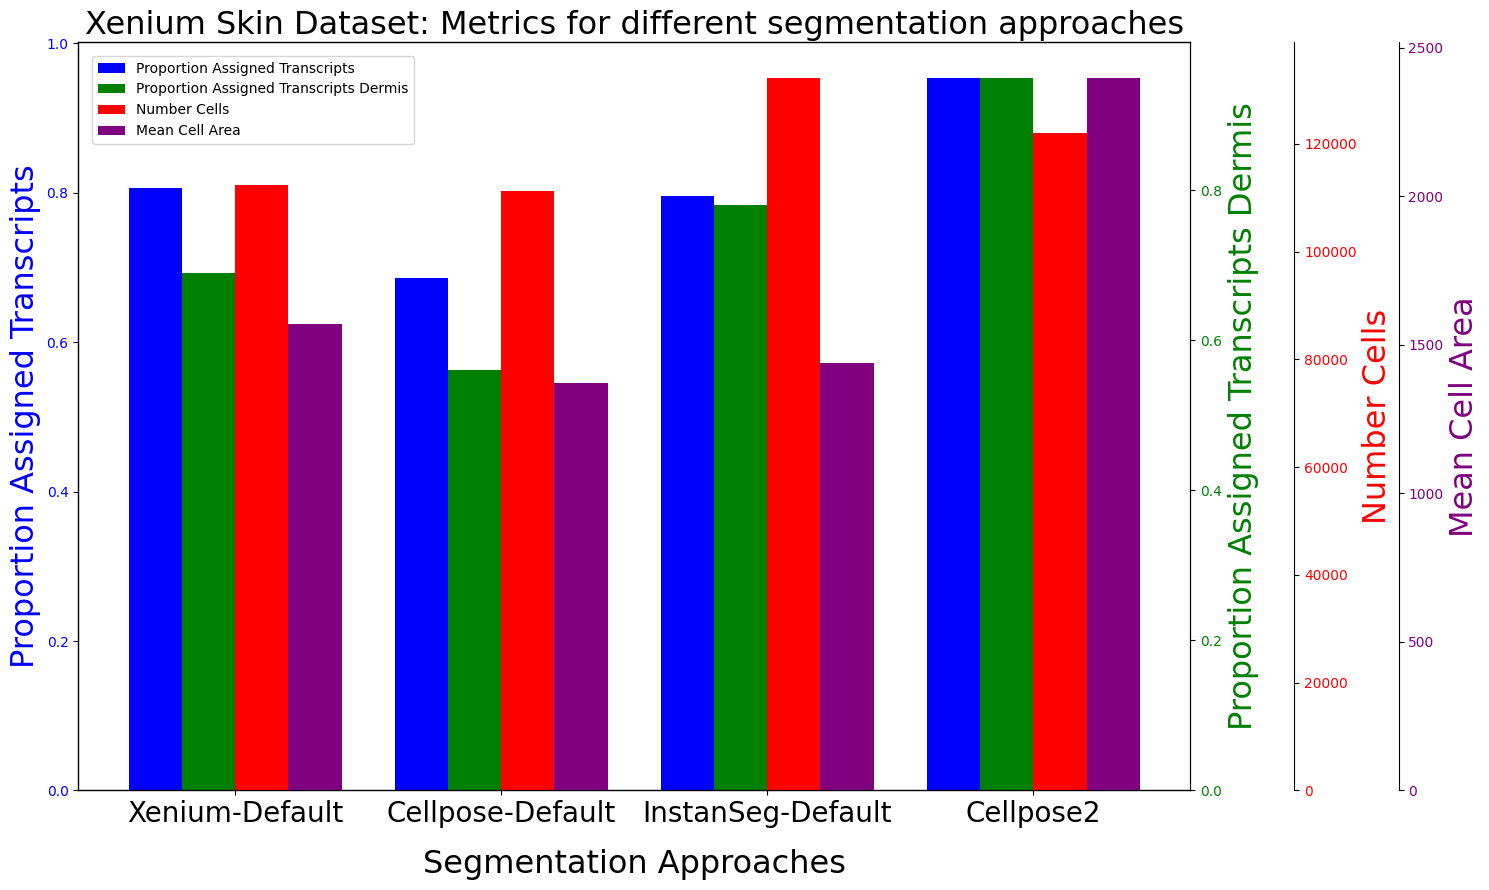

In [55]:
csv_files = [
    "data/segmentation_metrics_data/outputs/qc_segmentation_Xenium-Skin-Xenium-Default.csv", 
    "data/segmentation_metrics_data/outputs/qc_segmentation_Xenium-Skin-Cellpose-Default.csv", 
    "data/segmentation_metrics_data/outputs/qc_segmentation_Xenium-Skin-InstanSeg-Default.csv",
    "data/segmentation_metrics_data/outputs/qc_segmentation_Xenium-Skin-Cellpose2.csv"
]

combined_metrics = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    combined_metrics = pd.concat([combined_metrics, df], ignore_index=True)

combined_metrics.drop(['Unnamed: 0'], axis=1, inplace=True)

# add additional metric for dermis region
additional_metric = [0.69, 0.56, 0.78, 0.95]
combined_metrics["proportion_assigned_transcripts_dermis"] = additional_metric

metrics = ["proportion_assigned_transcripts", "proportion_assigned_transcripts_dermis", "number_cells", "mean_cell_area"]
segmentation_approaches = combined_metrics["segmentation_approach"].unique()

bar_width = 0.2
x = np.arange(len(segmentation_approaches))

fig, ax = plt.subplots(figsize=(15, 9))

# Primary axis for the first metric
ax.bar(x, combined_metrics[metrics[0]], width=bar_width, color='blue', label=metrics[0].replace("_", " ").title())
ax.set_ylabel(metrics[0].replace("_", " ").title(), color='blue', fontsize=23)
ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel("Segmentation Approaches", fontsize=23, labelpad=15)
ax.set_xticks(np.arange(0.3, 4.3, 1))
ax.set_xticklabels(segmentation_approaches, rotation=0, fontsize=20)
axes = [ax]  # Store the axes for legend handling

# Add secondary axes for other metrics
colors = ['green', 'red', 'purple']
for i, metric in enumerate(metrics[1:], start=1):
    ax_new = ax.twinx()
    ax_new.spines['right'].set_position(('outward', 75 * (i - 1)))  # Shift y-axis outward
    ax_new.bar(x + i * bar_width, combined_metrics[metric], width=bar_width, color=colors[i - 1], label=metric.replace("_", " ").title())
    ax_new.set_ylabel(metric.replace("_", " ").title(), color=colors[i - 1], fontsize=23)
    ax_new.tick_params(axis='y', labelcolor=colors[i - 1])
    axes.append(ax_new)

# Combine legends from all axes
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.06, 0.94))

# Title and layout adjustments
ax.set_title("Xenium Skin Dataset: Metrics for different segmentation approaches", fontsize=23)
plt.tight_layout()
plt.show()

In [4]:
# Lists of genes
t_cell_specific_genes = [
    "CD3D", "CD3E", "CD3G", "CD4", "CD8A", "CD8B", 
    "TRAC", "TRBC1", "TRBC2", "FOXP3", "TBX21", 
    "GATA3", "LCK", "ZAP70", "RORA", "RUNX3", "CCR7"
]

b_cell_specific_genes = [
    "CD19", "MS4A1", "CD79A", "CD79B", "PAX5", 
    "AICDA", "BLIMP1", "BCL6", "CXCR5", "IGHM", 
    "IGHG", "IGHA", "IGHE", "IGHD", "IGKC", "IGLC"
]

print("T-cell specific genes:", t_cell_specific_genes)
print("B-cell specific genes:", b_cell_specific_genes)

T-cell specific genes: ['CD3D', 'CD3E', 'CD3G', 'CD4', 'CD8A', 'CD8B', 'TRAC', 'TRBC1', 'TRBC2', 'FOXP3', 'TBX21', 'GATA3', 'LCK', 'ZAP70', 'RORA', 'RUNX3', 'CCR7']
B-cell specific genes: ['CD19', 'MS4A1', 'CD79A', 'CD79B', 'PAX5', 'AICDA', 'BLIMP1', 'BCL6', 'CXCR5', 'IGHM', 'IGHG', 'IGHA', 'IGHE', 'IGHD', 'IGKC', 'IGLC']


In [5]:
cbg_stp_cellpose2_file = "data/segmentation_metrics_data/xenium_skin_cellpose2/cell_by_gene_matrix.parquet"
cbg_stp_cellpose_default_file = "data/segmentation_metrics_data/xenium_skin_cellpose_default/cell_by_gene_matrix.parquet"
cbg_stp_instanseg_file ="data/segmentation_metrics_data/xenium_skin_instanseg_default/cell_by_gene_matrix.parquet"
cbg_xenium_file = "data/segmentation_metrics_data/xenium_skin_xenium_default/cell_by_gene_matrix.parquet"

/Users/jishar/anaconda3/envs/celldega_env/lib/python3.9/site-packages/seaborn/axisgrid.py:478: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")


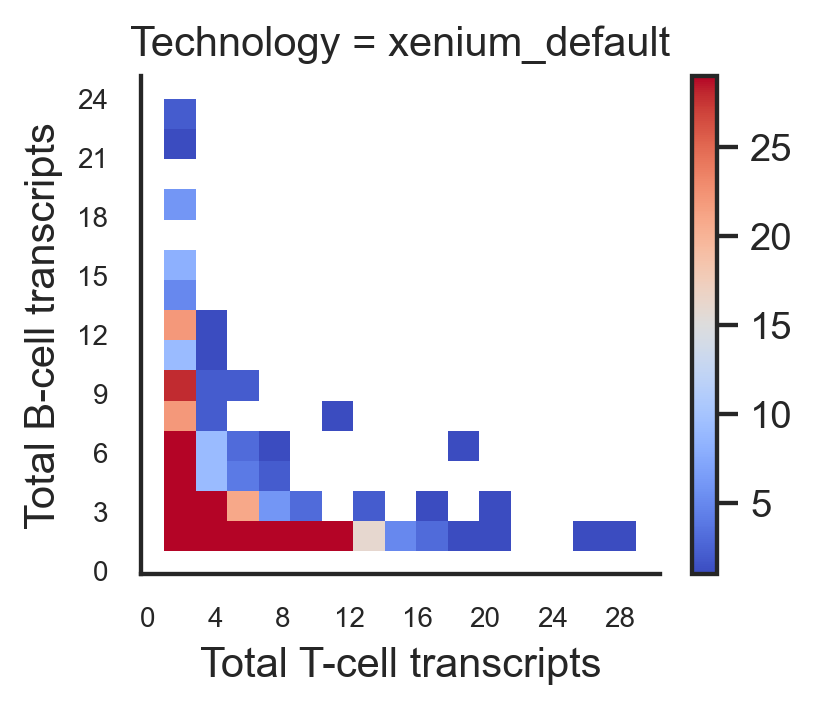

/Users/jishar/anaconda3/envs/celldega_env/lib/python3.9/site-packages/seaborn/axisgrid.py:478: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")


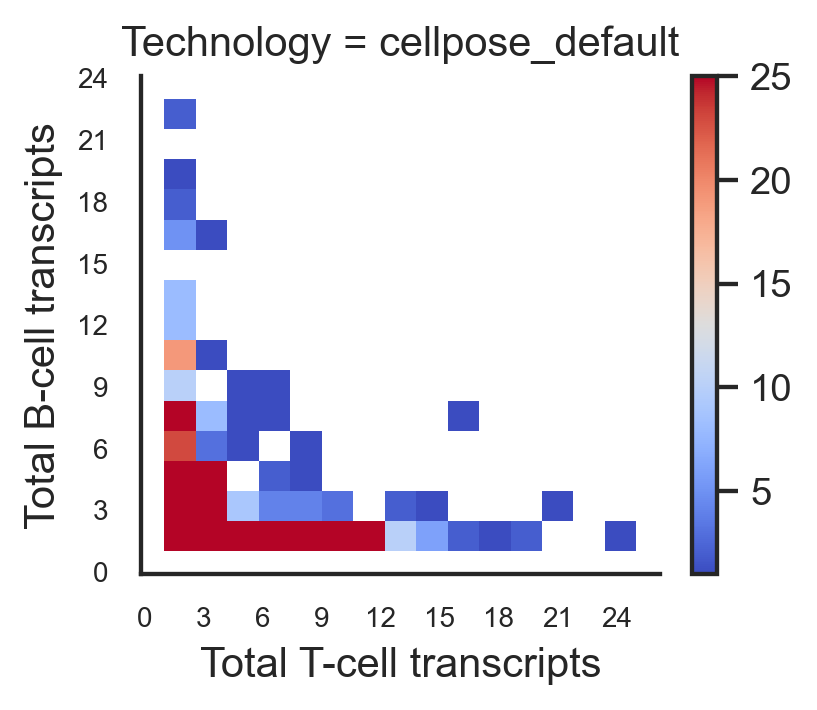

/Users/jishar/anaconda3/envs/celldega_env/lib/python3.9/site-packages/seaborn/axisgrid.py:478: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")


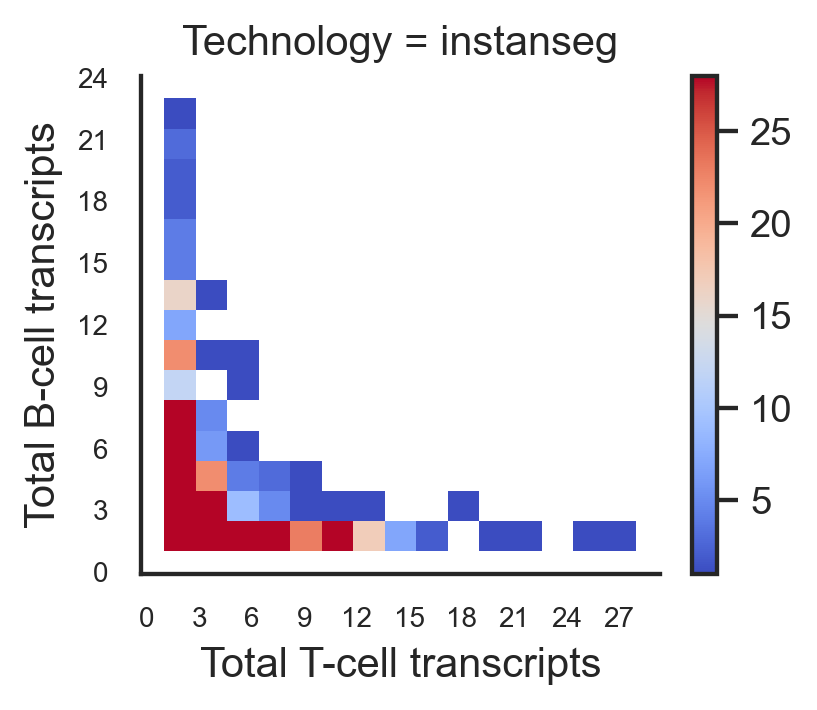

/Users/jishar/anaconda3/envs/celldega_env/lib/python3.9/site-packages/seaborn/axisgrid.py:478: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")


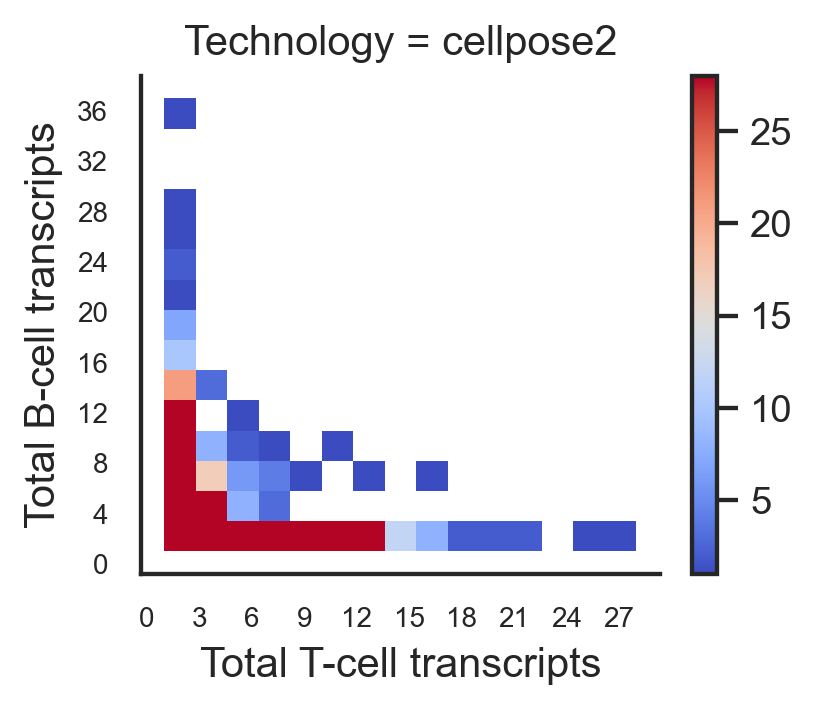

In [12]:
dega.qc.mixed_expression_calc(cbg_xenium_file, cbg_stp_cellpose_default_file, cbg_stp_instanseg_file, cbg_stp_cellpose2_file, t_cell_specific_genes, b_cell_specific_genes)